In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

# Объединяем test с gender_submission по PassengerId, чтобы добавить колонку Survived
test_merged = pd.merge(test, gender_submission, on='PassengerId')

# Объединяем train и test_merged в единый датафрейм
full_data = pd.concat([train, test_merged], ignore_index=True)

# Сохраняем в новый файл
full_data.to_csv('full_titanic.csv', index=False)

анализ данных

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


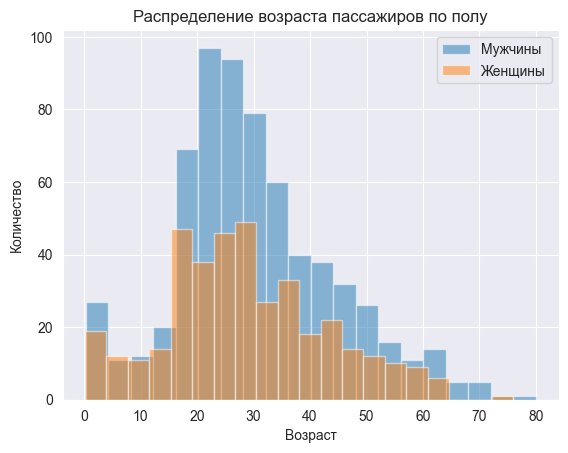

In [2]:
print(full_data.isnull().sum())
import matplotlib.pyplot as plt

men = full_data[full_data['Sex'] == 'male']['Age'].dropna()
women = full_data[full_data['Sex'] == 'female']['Age'].dropna()

plt.hist(men, bins=20, alpha=0.5, label='Мужчины')
plt.hist(women, bins=20, alpha=0.5, label='Женщины')
plt.legend()
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста пассажиров по полу')
plt.show()

def fill_age(row):
    if pd.isna(row['Age']):
        return full_data[(full_data['Pclass'] == row['Pclass']) & (full_data['Sex'] == row['Sex'])]['Age'].median()
    return row['Age']

full_data['Age'] = full_data.apply(fill_age, axis=1)

Разбить возраст на интервалы

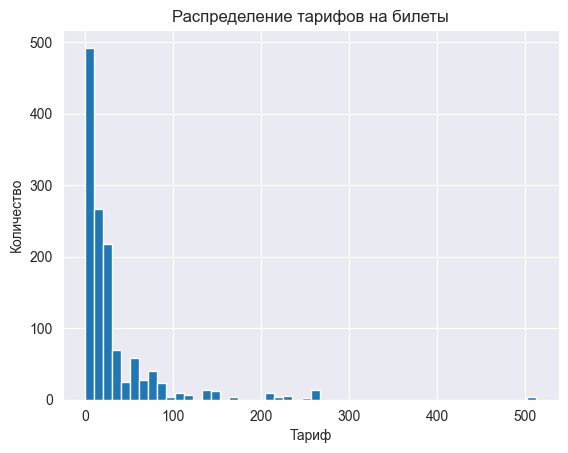

In [3]:
bins = [0, 18, 60, full_data['Age'].max() + 1]
labels = ['дети', 'средний возраст', 'старшие']
full_data['Age_Cat'] = pd.cut(full_data['Age'], bins=bins, labels=labels, right=False)
plt.hist(full_data['Fare'], bins=50)
plt.xlabel('Тариф')
plt.ylabel('Количество')
plt.title('Распределение тарифов на билеты')
plt.show()
suspicious_1class = full_data[(full_data['Pclass'] == 1) & (full_data['Fare'] < 10)]
suspicious_1class.to_csv('suspicious_fares.csv', index=False)

In [4]:
full_data['Family_Size'] = full_data['SibSp'] + full_data['Parch'] + 1
largest_families = full_data.sort_values('Family_Size', ascending=False).head(5)

выявление закономерностей

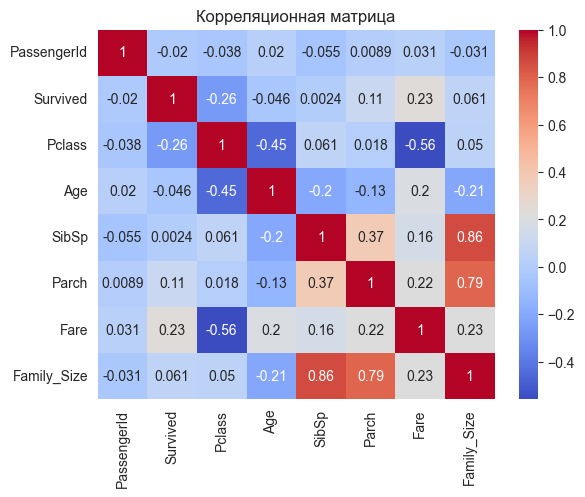

In [5]:
import seaborn as sns

numeric = full_data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

выделение признаков

In [6]:
print(full_data.groupby('Sex')['Survived'].mean())
print(full_data.groupby('Pclass')['Survived'].mean())
print(full_data.groupby('Age_Cat')['Survived'].mean())
print(full_data.groupby('Family_Size')['Survived'].mean())

Sex
female    0.82618
male      0.12930
Name: Survived, dtype: float64
Pclass
1    0.575851
2    0.422383
3    0.269394
Name: Survived, dtype: float64
Age_Cat
дети               0.506494
средний возраст    0.360538
старшие            0.350000
Name: Survived, dtype: float64
Family_Size
1     0.292405
2     0.531915
3     0.559748
4     0.720930
5     0.227273
6     0.200000
7     0.312500
8     0.125000
11    0.181818
Name: Survived, dtype: float64


/var/folders/4c/jkygkw1s1yj6cx40mzszqyg00000gn/T/ipykernel_5074/2241276391.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(full_data.groupby('Age_Cat')['Survived'].mean())


модель

In [7]:
prob = full_data.groupby(['Sex', 'Pclass'])['Survived'].mean().reset_index(name='Prob_Surv')
full_data = full_data.merge(prob, on=['Sex', 'Pclass'], how='left')
full_data.rename(columns={'Prob_Surv': 'Model_Surv'}, inplace=True)

full_data['Predicted'] = (full_data['Model_Surv'] > 0.5).astype(int)
accuracy = (full_data['Predicted'] == full_data['Survived']).mean()
print(accuracy)

def rule_survived(row):
    if (row['Sex'] == 'female' or row['Age'] < 18) and row['Pclass'] != 3:
        return 1
    return 0

full_data['Rule_Surv'] = full_data.apply(rule_survived, axis=1)
rule_accuracy = (full_data['Rule_Surv'] == full_data['Survived']).mean()
print(rule_accuracy)

0.8548510313216195
0.8029029793735676
